In [37]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn import svm,tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
#data = pd.concat([train_data, test_data],ignore_index = True)
print(test_data.shape)

(418, 11)


In [3]:
#test_data.info()
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
print(test_data.shape,end="")
print(train_data.shape)

(418, 11)(891, 12)


In [5]:
#train_data.apply(lambda x : len(x.unique()))
test_data.apply(lambda x : len(x.unique()))

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             80
SibSp            7
Parch            8
Ticket         363
Fare           170
Cabin           77
Embarked         3
dtype: int64

In [6]:
train_data.apply(lambda x : sum(x.isnull()))
test_data.apply(lambda x : sum(x.isnull()))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# xử lí missing value

In [7]:
#train_data.apply(lambda x : sum(x.isnull()))
test_data.apply(lambda x : sum(x.isnull()))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## dùng KNN dự đoán các giá trị còn thiếu

In [8]:
#Train_data
imputer_train = KNNImputer(n_neighbors=5)
imputer_train.fit(train_data.select_dtypes('float64'))
column_float = list(train_data.select_dtypes('float64').columns)
train_data[column_float] = imputer_train.transform(train_data.select_dtypes('float64'))

In [9]:
# Test_data
imputer_test = KNNImputer(n_neighbors=5)
imputer_test.fit(test_data.select_dtypes('float64'))
column_float = list(test_data.select_dtypes('float64').columns)
test_data[column_float] = imputer_test.transform(test_data.select_dtypes('float64'))

In [10]:
train_data.dropna(how = 'all', inplace=True,subset=['Embarked'])
#test_data.dropna(how = 'all', inplace=True,subset=['Fare'])
test_data.Fare.fillna(7.0,inplace = True)

In [11]:
train_data = train_data.drop(['Cabin'],axis=1) 
test_data = test_data.drop(['Cabin'],axis = 1)

In [12]:
train_data.apply(lambda x : sum(x.isnull()))
#test_data.apply(lambda x : sum(x.isnull()))


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## fill missing value success

# Data preprocessing

In [13]:
train_df = train_data.drop(['PassengerId','Name','Ticket'],axis = 1)
test_df = test_data.drop(['PassengerId','Name','Ticket'],axis = 1)

In [14]:
train_df.shape

(889, 8)

# Feature selection

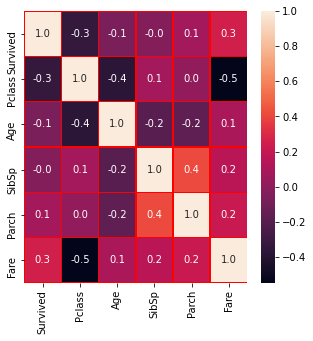

In [15]:
# select by heatmap
f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(train_df.corr(), annot=True, linewidths=0.5,linecolor="red", fmt= '.1f',ax=ax)
plt.show()

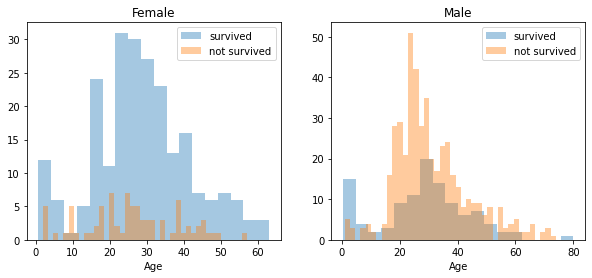

In [16]:
# tương quan giữa độ tuổi và tỉ lệ sống sót
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age, bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age, bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age, bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

In [17]:
# nhận xét : - phụ nữ ở độ tuổi từ 20 - 40 tuổi có tỉ lệ sống cao hơn so với đàn ông ở cùng độ tuổi

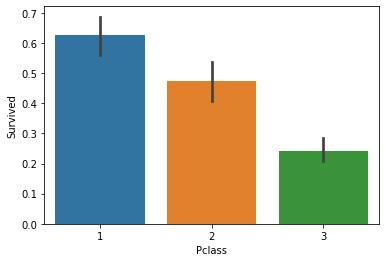

In [18]:
# tương quan giữa Class và survived
sns.barplot(x='Pclass', y='Survived', data=train_df)

In [19]:
# nhận xét: ta thấy hành khách ở class 1 có tỉ lệ sống cao nhất , tỉ lệ giảm dần ở các khoang khác

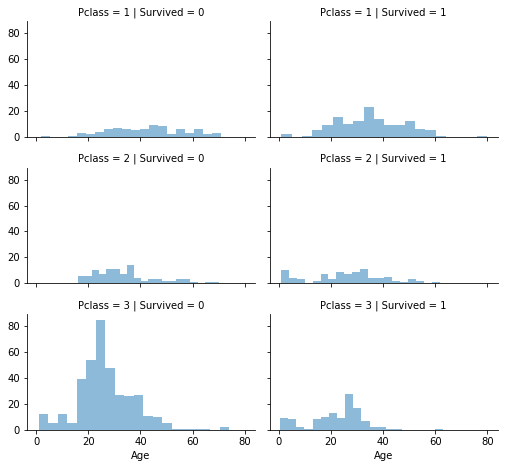

In [20]:
# độ tuổi, class và tỉ lệ sống sót
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

# convert String to float

In [21]:
sex = {'male' : 1.0, 'female' : 0.0}
train_df['Sex'] = train_df['Sex'].map(sex)
test_df['Sex'] = test_df['Sex'].map(sex)

In [22]:
train_df['Embarked'].value_counts()
embarked = {'S': 1.0, 'C' : 2.0, 'Q': 3.0}
train_df['Embarked'] = train_df['Embarked'].map(embarked)
test_df['Embarked'] = test_df['Embarked'].map(embarked)

In [23]:
intType = ['Pclass','SibSp','Parch']
for col in intType:
    train_df[col] = train_df[col].astype(float)
    test_data[col] = test_data[col].astype(float)

In [24]:
label = train_df.loc[:,'Survived']
train_df = train_df.drop('Survived',axis = 1)

# classification with SVM

In [25]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    float64
 1   Sex       889 non-null    float64
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    float64
 4   Parch     889 non-null    float64
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    float64
dtypes: float64(7)
memory usage: 95.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    float64
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 23.0 K

In [26]:
linear = svm.SVC(kernel = 'linear')
linear.fit(train_df, label)

SVC(kernel='linear')

In [27]:
result = linear.predict(test_df)

In [28]:
accuracy = round(linear.score(train_df,label)*100,2)

In [41]:
print("tỉ lệ:" ,accuracy)


tỉ lệ: 78.63


# Classification with Decision Tree

In [32]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(train_df,label)

DecisionTreeClassifier()

In [33]:
result_decision = classifier.predict(test_df)
print(round(classifier.score(train_df, label)*100,2))
print(type(result_decision))


98.2
<class 'numpy.ndarray'>


### nhận xét phân lớp bằng Decision tree cho kết quả khá chính xác

# classification with KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
neighbor = KNeighborsClassifier(n_neighbors = 5)
neighbor.fit(train_df, label)
result_knn = neighbor.predict(test_df)
print(round(neighbor.score(train_df, label)*100,2))

79.87


# classification with randomforestclassification

In [43]:
randomforest = RandomForestClassifier(n_estimators=80,max_features='auto',criterion='entropy',max_depth=4)
randomforest.fit(train_df,label)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=80)

In [44]:
result = randomforest.predict(test_df)
print(round(randomforest.score(train_df,label)*100,2))

84.25
